# The Pythagorean Expectation
"Pythagorean expectation is a sports analytics formula devised by Bill James to estimate the percentage of games a baseball team "should" have won based on the number of runs they scored and allowed. Comparing a team's actual and Pythagorean winning percentage can be used to make predictions and evaluate which teams are over-performing and under-performing. The name comes from the formula's resemblance to the Pythagorean theorem."

## Goal:
The goal of this analysis is to apply Pythagorean Expectation to predict which teams will under/overperform on the second half o the season. I am not going to focus on the details of all match statistics. Just on the Pythagorean Expectation analysis

## League:
I am going to focus on the English football league Premier League. Specifically on the last season that started at: 11/08/2023 and ended date: 19/05/2024.

"The Premier League is the highest level of the English football league system. Contested by 20 clubs, it operates on a system of promotion and relegation with the English Football League (EFL). Seasons usually run from August to May, with each team playing 38 matches: two against each other, one home and one away. Most games are played on weekend afternoons, with occasional weekday evening fixtures."

# Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Import data

In [2]:
fixtures = pd.read_csv('PremierLeague.csv')

pd.set_option('display.max_columns', None)

# Gather basic Information

In [3]:
# Data Size
print(f'Stats\nRows: {fixtures.shape[0]} \nCols: {fixtures.shape[1]}\n')

Stats
Rows: 380 
Cols: 8



In [4]:
fixtures.head()

,round_number,league_name,name,starting_at,home_team_name,away_team_name,home_team_goals,away_team_goals
0,1,Premier League,Burnley vs Manchester City,8/11/2023,Burnley,Manchester City,0,3
1,1,Premier League,Arsenal vs Nottingham Forest,8/12/2023,Arsenal,Nottingham Forest,2,1
2,1,Premier League,AFC Bournemouth vs West Ham United,8/12/2023,AFC Bournemouth,West Ham United,1,1
3,1,Premier League,Brighton & Hove Albion vs Luton Town,8/12/2023,Brighton & Hove Albion,Luton Town,4,1
4,1,Premier League,Everton vs Fulham,8/12/2023,Everton,Fulham,0,1


In [5]:
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   round_number     380 non-null    int64 
 1   league_name      380 non-null    object
 2   name             380 non-null    object
 3   starting_at      380 non-null    object
 4   home_team_name   380 non-null    object
 5   away_team_name   380 non-null    object
 6   home_team_goals  380 non-null    int64 
 7   away_team_goals  380 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 23.9+ KB


In [6]:
fixtures.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
round_number,380.0,19.50,10.98,1.0,10.0,19.5,29.0,38.0
home_team_goals,380.0,1.80,1.37,0.0,1.0,2.0,3.0,6.0
away_team_goals,380.0,1.48,1.28,0.0,1.0,1.0,2.0,8.0


In [7]:
fixtures[fixtures.duplicated()]

,round_number,league_name,name,starting_at,home_team_name,away_team_name,home_team_goals,away_team_goals


In [8]:
fixtures.isna().sum()

round_number       0
league_name        0
name               0
starting_at        0
home_team_name     0
away_team_name     0
home_team_goals    0
away_team_goals    0
dtype: int64

## Data Prep Pythagorean Expectation (First Half of the Season)

## Season 2022/2023 Premier League

### Filter rounds from 1 to 19 (half season)

In [9]:
half_season = fixtures[fixtures['round_number'].astype(int) <= 19]

In [10]:
# indicates if the team won when was playing home
half_season['home_win'] = [1 if  h > v else 0.5 if h == v else 0  \
                           for h, v in zip(half_season['home_team_goals'],half_season['away_team_goals'])]


# indicates if the team won when was playing away
half_season['away_win'] = [1 if  v > h  else 0.5 if h == v else 0   \
                           for h, v in zip(half_season['home_team_goals'], half_season['away_team_goals'])]

half_season['count'] = 1

In [11]:
# Points System
WIN = 3
DRAW = 1

In [12]:
# Calculate the number of points playing home
half_season['home_points'] = [WIN if h > a else DRAW if h ==  a else 0 \
                              for h, a in zip(half_season['home_win'], half_season['away_win'])] 

In [13]:
# Calculate the number of points playing away
half_season['away_points'] = [WIN if a > h else DRAW if a ==  h else 0 \
                              for h, a in zip(half_season['home_win'], half_season['away_win'])] 

In [14]:
# Summarize total matches won at home and total goals
home_team = (half_season[['home_team_name','home_win','home_team_goals','away_team_goals','home_points','count']]
                 .groupby(['home_team_name'])
                 .sum()
                 .reset_index()
                 .rename(columns={'home_team_name': 'team', 'count':'Ph', 'home_team_goals':'FTHGh','away_team_goals':'FTAGh' })
            )

In [15]:
# Summarize total matches won away and total goals
away_team = (half_season[['away_team_name','away_win','away_team_goals','home_team_goals','away_points','count']]
                 .groupby(['away_team_name'])
                 .sum()
                 .reset_index()
                 .rename(columns={'away_team_name': 'team', 'count':'Pa','away_team_goals':'FTAGa', 'home_team_goals':'FTHGa'})
            )

In [16]:
# Summarize total wins home
total_home_win = (half_season[['home_team_name', 'home_win']][half_season['home_win'] == 1]
                        .groupby('home_team_name')
                        .count()
                        .reset_index()
                    )
# Summarize total lost home
total_home_lost = (half_season[['home_team_name', 'home_win']][half_season['home_win'] == 0]
                        .groupby('home_team_name')
                        .count()
                        .reset_index()
                    )

# Summarize total draw home
total_home_draw = (half_season[['home_team_name', 'home_win']][half_season['home_win'] == 0.5]
                        .groupby('home_team_name')
                        .count()
                        .reset_index()
                    )

In [17]:
# Summarize total draw away
total_away_win = (half_season[['away_team_name', 'away_win']][half_season['away_win'] == 1]
                        .groupby('away_team_name')
                        .count()
                        .reset_index()
                    )
# Summarize total draw away
total_away_lost = (half_season[['away_team_name', 'away_win']][half_season['away_win'] == 0]
                        .groupby('away_team_name')
                        .count()
                        .reset_index()
                    )
# Summarize total draw away
total_away_draw = (half_season[['away_team_name', 'away_win']][half_season['away_win'] == 0.5]
                        .groupby('away_team_name')
                        .count()
                        .reset_index()
                    )

In [18]:
# Summary table home
table_home = (total_home_win.merge(total_home_lost, how='left', on='home_team_name')
                                     .merge(total_home_draw, how='left', on='home_team_name')
                    ).rename(columns={'home_team_name':'Team', 'home_win_x':'Home_Win','home_win_y':'Home_Lost',\
                                      'home_win':'Home_Draw'}).fillna(0)

In [19]:
# Summary table home
table_away = (total_away_win.merge(total_away_lost, how='right', on='away_team_name')
                                      .merge(total_away_draw, how='right', on='away_team_name')
                     ).rename(columns={'away_team_name':'Team', 'away_win_x':'Away_Win','away_win_y':'Away_Lost',\
                                       'away_win':'Away_Draw'}).fillna(0)

In [20]:
# Joining summary tables
total_matches = table_home.merge(table_away, how='left', on='Team')

In [21]:
# Totals
total_matches['total_win']  = (total_matches['Home_Win'] + total_matches['Away_Win']).astype(int)
total_matches['total_lost'] = (total_matches['Home_Lost'] + total_matches['Away_Lost']).astype(int)
total_matches['total_draw'] = (total_matches['Home_Draw'] + total_matches['Away_Draw']).astype(int)

In [22]:
# joining matches summary
summary_half_season = (away_team.merge(home_team, left_on='team', right_on='team')
                       )

In [23]:
summary_half_season['total_points'] = summary_half_season['home_points'] + summary_half_season['away_points']

In [24]:
summary_half_season.head()

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points
0,AFC Bournemouth,4.5,16,20,13,9,5.5,15,15,15,10,28
1,Arsenal,6.0,14,8,17,9,8.0,22,10,23,10,40
2,Aston Villa,5.0,14,19,14,10,8.5,26,6,25,9,39
3,Brentford,2.5,8,11,7,9,4.5,17,18,12,10,19
4,Brighton & Hove Albion,4.0,16,19,11,9,7.0,22,14,19,10,30


# Pythagorean Expectation

In [25]:
# Calculate Total wins, games, played, goals for and goals against (home team and away team
summary_half_season['W']=summary_half_season['home_win']+summary_half_season['away_win']
summary_half_season['G']=summary_half_season['Ph']+summary_half_season['Pa']
summary_half_season['GF']=summary_half_season['FTHGh']+summary_half_season['FTAGa']
summary_half_season['GA']=summary_half_season['FTAGh']+summary_half_season['FTHGa']
summary_half_season.head(2)

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points,W,G,GF,GA
0,AFC Bournemouth,4.5,16,20,13,9,5.5,15,15,15,10,28,10.0,19,31,35
1,Arsenal,6.0,14,8,17,9,8.0,22,10,23,10,40,14.0,19,36,18


In [26]:
# Calculate the percentage of win and pythagorean expectation
summary_half_season['wpc'] = summary_half_season['W']/summary_half_season['G']

summary_half_season['pyth'] = summary_half_season['GF']**2/(summary_half_season['GF']**2 + summary_half_season['GA']**2)
summary_half_season.head(2)

,team,away_win,FTAGa,FTHGa,away_points,Pa,home_win,FTHGh,FTAGh,home_points,Ph,total_points,W,G,GF,GA,wpc,pyth
0,AFC Bournemouth,4.5,16,20,13,9,5.5,15,15,15,10,28,10.0,19,31,35,0.526316,0.439616
1,Arsenal,6.0,14,8,17,9,8.0,22,10,23,10,40,14.0,19,36,18,0.736842,0.800000


# Exploratory Data Analysis

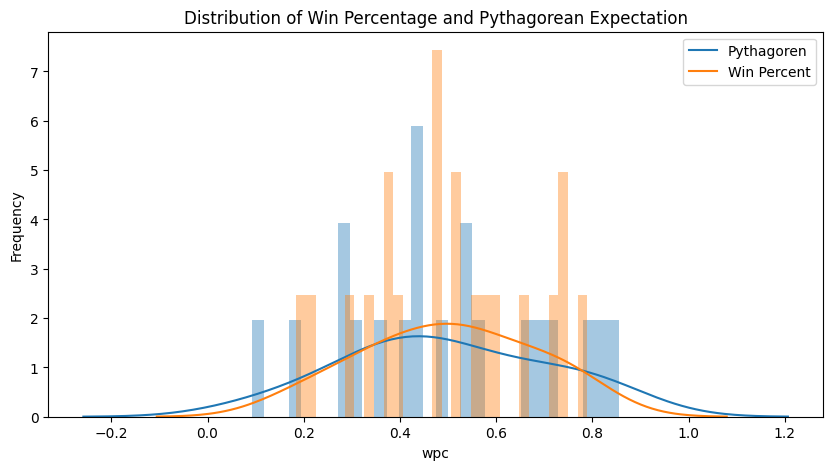

In [28]:
plt.figure(figsize=(10,5))
plt.title('Distribution of Win Percentage and Pythagorean Expectation')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
sns.distplot(summary_half_season['pyth'], bins= 30)
sns.distplot(summary_half_season['wpc'], bins=30)
plt.legend(['Pythagoren', 'Win Percent']);

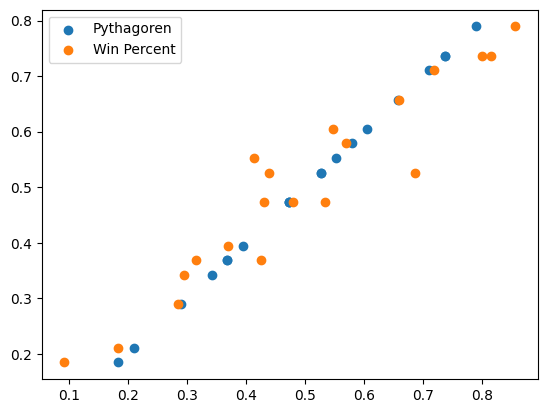

In [29]:
plt.scatter(summary_half_season['wpc'],summary_half_season['wpc'])
plt.scatter(summary_half_season['pyth'], summary_half_season['wpc'])

plt.legend(['Pythagoren', 'Win Percent']);

Correlation: 0.952


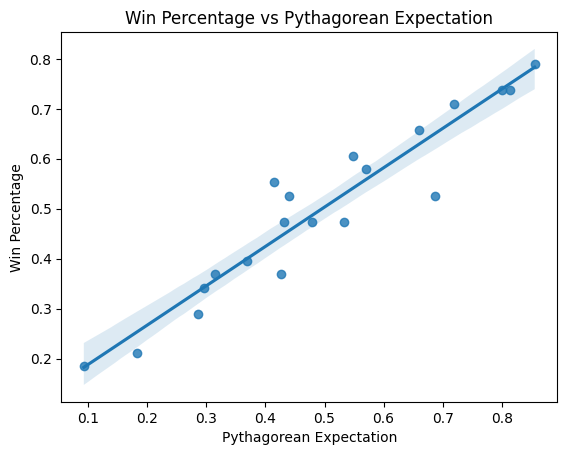

In [30]:
sns.regplot(data=summary_half_season,
               x = 'pyth',
               y= 'wpc'
              )
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs Pythagorean Expectation')

print(f"Correlation: {summary_half_season['pyth'].corr(summary_half_season['wpc']).round(3)}")

# Evaluating the results running a regression analysis

In [31]:
# Run the regression
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data=summary_half_season).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     175.0
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.03e-10
Time:                        18:58:47   Log-Likelihood:                 30.626
No. Observations:                  20   AIC:                            -57.25
Df Residuals:                      18   BIC:                            -55.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1097      0.032      3.429      0.003       0.042       0.177
pyth           0.7872      0.059     13.230      0.000       0.662       0.912
==============================================================================
Omnibus:                        1.320   Durbin-Watson:                   2.483
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                0.245
Skew:                          -0.130   Prob(JB):                        0.885
Kurtosis:                       3.477   Cond. No.                         6.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The histogram showed a similar distribution between the Win percentage and Pythagorean Expectation.
* The scatterplot with the regression line showed a positive linear relationship between Win percentage and Pythagorean Expectation with a Pearson's Correlation of 0.952
* The Regression resuls resulted in a R² of 0.907 for explained variance between the percentage and Pythagorean Expectation with a p-value smaller than 0.05 . Intercept * 0.1097, slope 0.782 indicating a very close relationship.

# Results

In [33]:
# Calculate the difference between expected and actual
summary_half_season['total_wins'] = summary_half_season['G'] * summary_half_season['pyth']

In [34]:
# Calculate the difference between expected and actual
summary_half_season['expected_wins'] = summary_half_season['G'] * summary_half_season['pyth']

In [35]:
# Calculate wins above/below expected
summary_half_season['wins_above_expected'] = summary_half_season['W'] -  summary_half_season['expected_wins']

In [36]:
summary_half_season = summary_half_season.merge(total_matches[['Team','total_win','total_lost','total_draw']], \
                                                left_on='team', right_on='Team')

In [37]:
cols = ['team', 'total_points','wpc','pyth','W','expected_wins', 'wins_above_expected', 'total_win', 'total_lost','total_draw']

In [38]:
# Creating table results
table_first_half = (summary_half_season[cols]
        .sort_values('W', ascending=False)
)

table_first_half.index = np.arange(1, len(table_first_half)+1)

table_first_half.columns = ['Team', 'Total Points', 'Win Percentage',' Pythagorean Expectation', 'Wins/Draw', 'Expected Wins',\
                           'Wins Above/Below Expected', 'Total Win', 'Total Lost','Total Draw']

In [39]:
table_first_half.style.background_gradient(axis=0, subset=['Wins Above/Below Expected'])

,Team,Total Points,Win Percentage,Pythagorean Expectation,Wins/Draw,Expected Wins,Wins Above/Below Expected,Total Win,Total Lost,Total Draw
1,Liverpool,42,0.789474,0.855937,15.000000,16.262802,-1.262802,12,1,6
2,Arsenal,40,0.736842,0.800000,14.000000,15.200000,-1.200000,12,3,4
3,Manchester City,40,0.736842,0.814472,14.000000,15.474968,-1.474968,12,3,4
4,Aston Villa,39,0.710526,0.719101,13.500000,13.662921,-0.162921,12,4,3
5,Tottenham Hotspur,36,0.657895,0.659870,12.500000,12.537527,-0.037527,11,5,3
6,West Ham United,33,0.605263,0.547511,11.500000,10.402715,1.097285,10,6,3
7,Brighton & Hove Albion,30,0.578947,0.570075,11.000000,10.831425,0.168575,8,5,6
8,Manchester United,31,0.552632,0.413696,10.500000,7.860225,2.639775,10,8,1
9,Newcastle United,29,0.526316,0.686560,10.000000,13.044634,-3.044634,9,8,2
10,AFC Bournemouth,28,0.526316,0.439616,10.000000,8.352699,1.647301,8,7,4


* Considering Manchester United and Newcastle United that resulted in a more extreme difference.
* Manchester United(8) resulted in 2.69 indicating that the team overperformed in the first half of the season. There is a signifcant chance that team will perform poorly on the second half of the season
* Newcastle United(9) resulted in -3.04 indicating that the team underperformed in the first half of the season. There is a significant chance that the team will perform better on the second half of the season
* It seems that the other teams are going to perform close to expected for the second half of the season. They are in a comfortable position.